In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

# Simple Linear Regression

$y = ax + b$

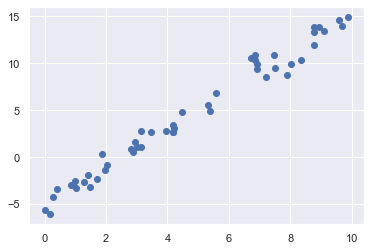

In [2]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = 2 * x - 5 + rng.randn(50)
plt.scatter(x, y);

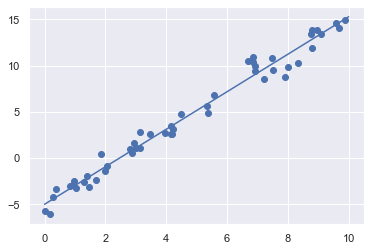

In [3]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

model.fit(x[:, np.newaxis], y)

xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

In [4]:
print('Model slope:'.ljust(16, ' '), model.coef_[0])
print('Model intercept:'.ljust(16, ' '), model.intercept_)

Model slope:     2.027208810360695
Model intercept: -4.998577085553202


In [5]:
rng = np.random.RandomState(1)
X = 10 * rng.rand(100, 3)
y = 0.5 + np.dot(X, [1.5, -2., 1.])

model.fit(X, y)
print(model.intercept_)
print(model.coef_)

0.5000000000000064
[ 1.5 -2.   1. ]


# Basis Function Regression

## Polynomial basis functions

In [6]:
from sklearn.preprocessing import PolynomialFeatures
x = np.array([2, 3, 4])
poly = PolynomialFeatures(3, include_bias=False)
poly.fit_transform(x[:, None])

array([[ 2.,  4.,  8.],
       [ 3.,  9., 27.],
       [ 4., 16., 64.]])

In [7]:
from sklearn.pipeline import make_pipeline
poly_model = make_pipeline(PolynomialFeatures(7),
                           LinearRegression())

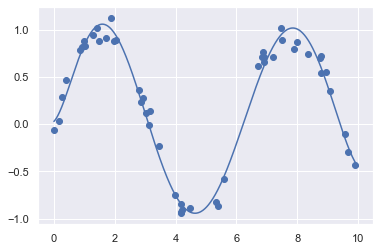

In [8]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)

poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

## Gaussian basis functions

(0, 10)

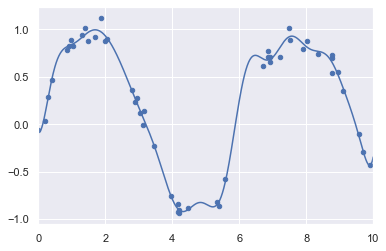

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin

class GaussianFeatures(BaseEstimator, TransformerMixin):
    """ Uniformly spaced Gaussian features for one-dimensional input """
    
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
        
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
    
    def fit(self, X, y=None):
        # create N centers spread aLong the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
    
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_,
                                  self.width_, axis=1)
    
gauss_model = make_pipeline(GaussianFeatures(20),
                            LinearRegression())
gauss_model.fit(x[:, np.newaxis], y)
yfit = gauss_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y, s=20)
plt.plot(xfit, yfit)
plt.xlim(0, 10)

# Regularization

- if we choose too many Gaussian basis functions, we end up width results that don't look so good: `over-fitting`

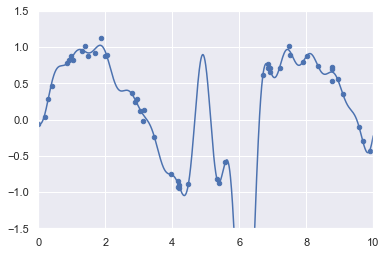

In [10]:
model = make_pipeline(GaussianFeatures(30),
                      LinearRegression())
model.fit(x[:, np.newaxis], y)

plt.scatter(x, y, s=20)
plt.plot(xfit, model.predict(xfit[:, np.newaxis]))

plt.xlim(0, 10)
plt.ylim(-1.5, 1.5);

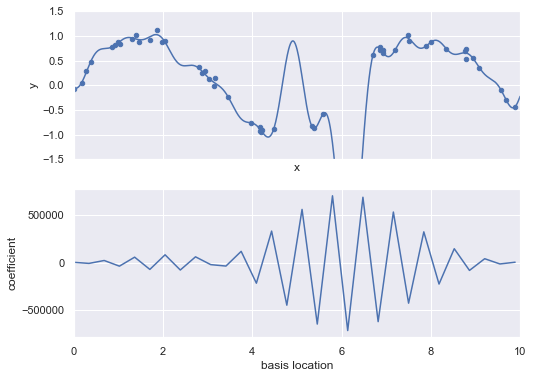

In [11]:
def basis_plot(model, title=None):
    fig, ax = plt.subplots(2, sharex=True, figsize=(8, 6))
    model.fit(x[:, np.newaxis], y)
    ax[0].scatter(x, y, s=20)
    ax[0].plot(xfit, model.predict(xfit[:, np.newaxis]))
    ax[0].set(xlabel='x', ylabel='y', ylim=(-1.5, 1.5))
    
    if title:
        ax[0].set_title(title)
        
    ax[1].plot(model.steps[0][1].centers_,
               model.steps[1][1].coef_)
    ax[1].set(xlabel='basis location',
              ylabel='coefficient',
              xlim=(0, 10))
    
model = make_pipeline(GaussianFeatures(30), LinearRegression())
basis_plot(model)

## Ridge regression ($L_2$ Regularization)

$P = \alpha\sum^N_{n=1}\theta^2_n$

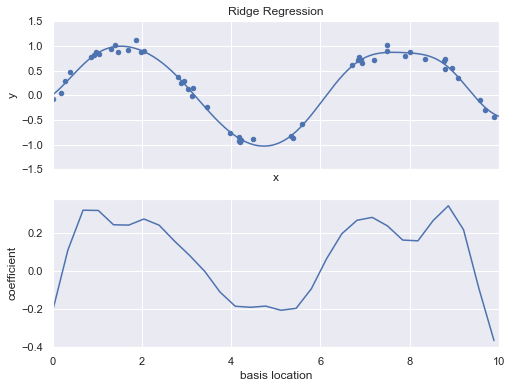

In [12]:
from sklearn.linear_model import Ridge
model = make_pipeline(GaussianFeatures(30), Ridge(alpha=0.1))
basis_plot(model, title='Ridge Regression')

## Lasso regression ($L_1$ regularization)
$P = \alpha\sum^N_{n=1}|\theta_n|$

C:\Users\imdff\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002135815870486668, tolerance: 0.002065280097246271
  positive)


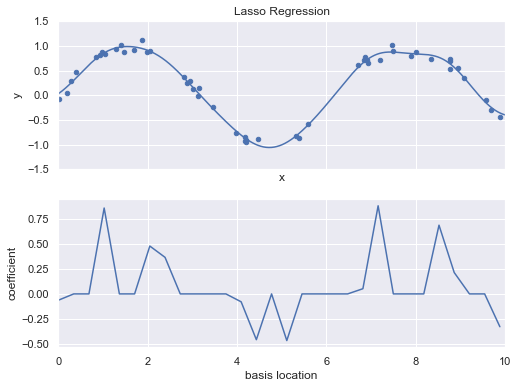

In [13]:
from sklearn.linear_model import Lasso
model = make_pipeline(GaussianFeatures(30), Lasso(alpha=0.001))
basis_plot(model, title='Lasso Regression');

# Example : Predicting Bicycle Traffic

In [14]:
# !curl -o FremontBridge.csv https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD

In [15]:
import pandas as pd
counts = pd.read_csv('data/FremontBridge.csv', index_col='Date', parse_dates=True)
weather = pd.read_csv('data/BicycleWeather.csv', index_col='DATE', parse_dates=True)

In [34]:
daily = counts.resample('d').sum()
daily = daily[['Fremont Bridge Total']]
daily.columns = ['Total']
daily.head()

,Total
Date,
2012-10-03,3521.0
2012-10-04,3475.0
2012-10-05,3148.0
2012-10-06,2006.0
2012-10-07,2142.0


In [35]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)
daily.tail()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun
Date,,,,,,,,
2019-11-26,3329.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2019-11-27,2576.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2019-11-28,579.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2019-11-29,1857.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2019-11-30,628.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [36]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2020')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
#daily['holiday'] = pd.Series(1, index=holidays, name='holiday')
daily['holiday'].fillna(0, inplace=True)
daily.tail()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday
Date,,,,,,,,,
2019-11-26,3329.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-11-27,2576.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2019-11-28,579.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2019-11-29,1857.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2019-11-30,628.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


(8, 17)

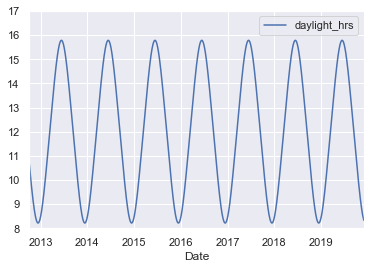

In [37]:
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 12)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()
plt.ylim(8, 17)

In [38]:
# temperatures are in 1/10 deg C; convert to C
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

# precip is in 1/10 mm; convert to inches
weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])

In [39]:
daily['annual'] = (daily.index - daily.index[0]).days / 365

In [40]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,10.758314,0.0,13.35,1.0,0.000000
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,10.701479,0.0,13.60,1.0,0.002740
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,10.644852,0.0,15.30,1.0,0.005479
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,10.588444,0.0,15.85,1.0,0.008219
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10.532267,0.0,15.85,1.0,0.010959


In [42]:
# Drop any rows with null values
daily.dropna(axis=0, how='any', inplace=True)

column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)', 'annual']
X = daily[column_names]
y = daily['Total']

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
daily['predicted'] = model.predict(X)

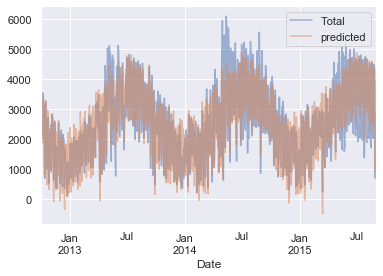

In [43]:
daily[['Total', 'predicted']].plot(alpha=0.5);

In [44]:
params = pd.Series(model.coef_, index=X.columns)
params

Mon              573.850804
Tue              682.057751
Wed              666.192917
Thu              555.207370
Fri              250.873971
Sat            -1030.779307
Sun            -1061.209101
holiday        -1180.844081
daylight_hrs     114.180226
PRCP            -667.499676
dry day          555.309008
Temp (C)          73.794593
annual            19.541659
dtype: float64

In [45]:
from sklearn.utils import resample
np.random.seed(1)
err = np.std([model.fit(*resample(X, y)).coef_
              for i in range(1000)], 0)

In [46]:
print(pd.DataFrame({'effect': params.round(0),
                    'error': err.round(0)}))

              effect  error
Mon            574.0   84.0
Tue            682.0   80.0
Wed            666.0   80.0
Thu            555.0   82.0
Fri            251.0   77.0
Sat          -1031.0   76.0
Sun          -1061.0   79.0
holiday      -1181.0  165.0
daylight_hrs   114.0    8.0
PRCP          -667.0   62.0
dry day        555.0   33.0
Temp (C)        74.0    3.0
annual          20.0   18.0
